### Create FISTA solution for TotalVariation

Initialised GradientOperator with C backend running with  14  threads
Initialised GradientOperator with C backend running with  14  threads
FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          2.08613e+04
      100        500         0.003          1.96689e+04
      200        500         0.003          1.96688e+04
      300        500         0.003          1.96688e+04
      400        500         0.003          1.96688e+04
      500        500         0.003          1.96688e+04
-------------------------------------------------------
      500        500         0.003          1.96688e+04
Stop criterion has been reached.



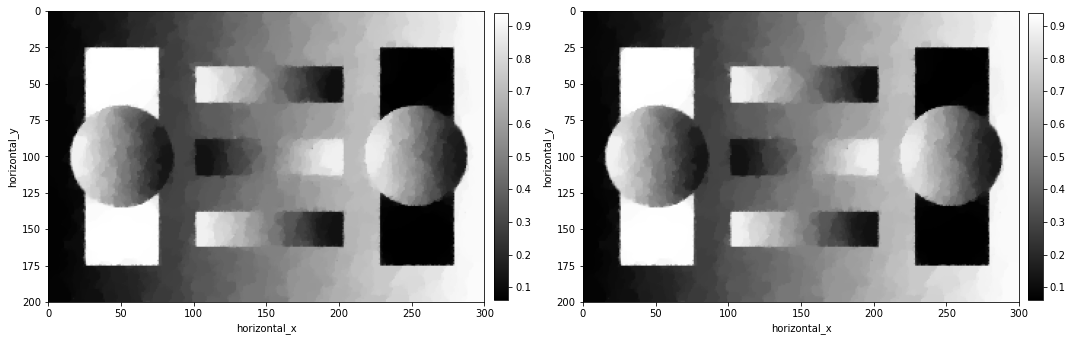

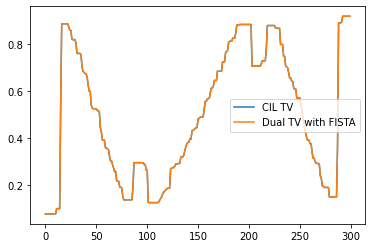

In [8]:
from cil.framework import ImageGeometry
from cil.optimisation.operators import LinearOperator, GradientOperator
from cil.optimisation.functions import Function
from cil.optimisation.functions import MixedL21Norm, LeastSquares
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import TotalVariation
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D
import numpy as np
import matplotlib.pyplot as plt

class AdjointOperator(LinearOperator):
    
    def __init__(self, operator):
        super(AdjointOperator, self).__init__(domain_geometry=operator.range_geometry(), 
                                       range_geometry=operator.domain_geometry())         
        self.operator = operator
                
    def direct(self, x, out=None):
        return self.operator.adjoint(x, out=out)
        
    def adjoint(self, x, out=None):
        return self.operator.direct(x, out=out)
    
class IndicatorMixedL21Norm(Function):
    
    def __init__(self, function):
        
        self.function = function
        super(IndicatorMixedL21Norm).__init__()
        
    def __call__(self,x):
        
        # should check for the norm set inf or 0. Return 0 atm.
        return 0.0
    
    def proximal(self, x, tau, out=None):
        
        return self.function.proximal_conjugate(x, tau, out=out)    
          
        
# Load data
data = dataexample.SHAPES.get()

# Add gaussian noise
noisy_data = noise.gaussian(data, seed = 10, var = 0.02)     

# reg parameter
alpha = 0.15
# solve with TotalVariation proximal method
TV = alpha*TotalVariation(max_iteration=500)
proxTV = TV.proximal(noisy_data, tau=1.0)

# setup the dual of TV and solve with FISTA
ig = noisy_data.geometry
Grad = GradientOperator(ig)
Div = -AdjointOperator(Grad) 

F = LeastSquares(A = Div, b=-1*noisy_data)
tmp = alpha * MixedL21Norm()
G = IndicatorMixedL21Norm(tmp)

initial= Div.domain.allocate()
fista = FISTA(initial=initial, f=F, g=G, max_iteration=500, update_objective_interval=100)
fista.run()
tmp_q = fista.solution
solution = noisy_data + (Div.direct(tmp_q))

show2D([proxTV,solution], num_cols=2, origin="upper")
plt.figure()
plt.plot(proxTV.array[100,:], label="CIL TV")
plt.plot(solution.array[100,:], label="Dual TV with FISTA")
plt.legend()
plt.show()

np.testing.assert_allclose(proxTV.array, solution.array, atol=1e-3)